### 1. Pacotes

Para iniciar a análise de séries temporais, começaremos carregando os pacotes necessários:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
import warnings
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
warnings.filterwarnings("ignore")

### 2. Base de Dados

Começamos carregando a base de dados para a variável _df_ e inspecionando as 10 primeiras linhas:

In [3]:
df = pd.read_excel('time_series_data.xlsx')

In [4]:
df.head(10)

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
0,A0,23568,UN,14.13,20210420
1,A0,25082,UN,14.13,20210420
2,A0,25430,UN,14.13,20210922
3,A0,25463,UN,12.84,20210209
4,A0,25800,UN,12.84,20210209
5,A0,25864,UN,12.84,20210202
6,A0,25872,UN,12.84,20210210
7,A0,25963,UN,14.13,20210930
8,A0,25978,UN,12.84,20210203
9,A0,26035,UN,14.13,20210922


In [5]:
df.shape

(4460, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   produto_descricao                       4460 non-null   object 
 1   produto_quantidade                      4460 non-null   int64  
 2   produto_unidade_comercial               4460 non-null   object 
 3   produto_valor_unitario_comercializacao  4460 non-null   float64
 4   nota_data_emissao                       4460 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3+ KB


Através de _.shape_ e _.info()_ pode-se perceber que _df_ é composto por 5 colunas referentes à descrição do produto, quantidade, unidade comercial, preço e data. Podemos notar também que não há _missing values_, o que facilita o processo de preparação dos dados. Com isso, iremos inspecionar quantas linhas correspondem a cada produto (_produto_descricao_) para selecionar o que possuir a maior quantidade de registros:

In [7]:
df['produto_descricao'].value_counts()

B0    1000
B3     887
B2     778
A8     662
B1     536
B4     307
A9     141
D0      33
A0      32
B6      17
A7      14
A5       8
B7       6
A6       6
C5       4
C3       3
C0       3
C1       3
B8       2
B5       2
C2       2
C7       2
C9       2
D1       2
B9       1
A1       1
A3       1
C4       1
A4       1
C6       1
C8       1
A2       1
Name: produto_descricao, dtype: int64

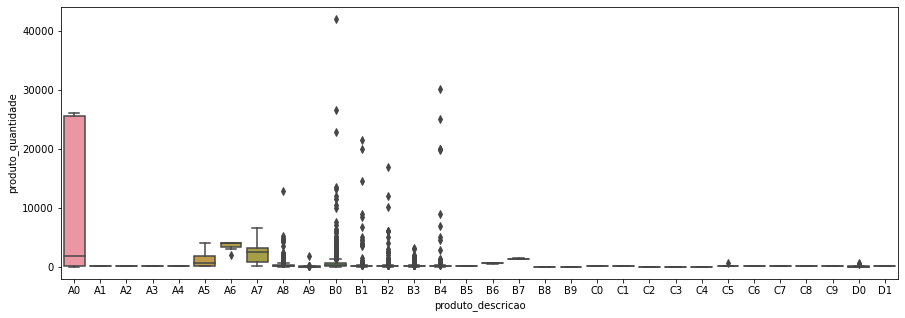

In [8]:
fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x="produto_descricao", y="produto_quantidade", data=df)

Apesar de possuir _outliers_ -- conforme apontado pelo boxplot acima -- o projeto prosseguirá com os dados referentes ao produto B0, devido à sua quantidade de observações.

In [9]:
produto = df[df['produto_descricao'] == 'B0']

In [10]:
produto.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
52,B0,2,UN,32.02,20210610
53,B0,60,UN,29.09,20210228
54,B0,60,UN,32.02,20210508
55,B0,60,UN,32.02,20210724
56,B0,120,UN,29.09,20210329


Após a seleção dos dados referentes ao produto B0, transformaremos a coluna _nota_data_emissao_ para o tipo de dado apropriado e, como possui _gaps_ entre as datas, alteraremos o formato de "ano/mês/dia" para "ano/semana":

In [11]:
produto['nota_data_emissao'] = produto['nota_data_emissao'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [12]:
produto['semana'] = produto['nota_data_emissao'].dt.strftime('%Y-%U')

Em uma análise de séries temporais, é necessário que os dados estejam ordenados conforme o tempo, com isso utilizaremos os dados semanais como _index_ e o organizaremos em forma cronológica:

In [13]:
produto = produto.set_index(['semana'])
produto = produto.groupby(['semana']).sum()

Também criaremos uma coluna com o logaritmo natural de _produto_quantidade_:

In [14]:
produto['log_quantidade'] = np.log(produto['produto_quantidade'])
produto.head()

,produto_quantidade,produto_valor_unitario_comercializacao,log_quantidade
semana,,,
2020-39,134,30.47,4.897840
2020-40,1310,292.24,7.177782
2020-41,9324,974.66,9.140347
2020-42,6427,668.90,8.768263
2020-43,8088,803.82,8.998137


In [15]:
produto = produto.sort_values(by='semana')

In [16]:
produto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 2020-39 to 2021-39
Data columns (total 3 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   produto_quantidade                      47 non-null     int64  
 1   produto_valor_unitario_comercializacao  47 non-null     float64
 2   log_quantidade                          47 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.5+ KB


Podemos verificar que o número de observações foi reduzido para 47.
A seguir será feito uma breve AED, começando por _produto_quantidade_:

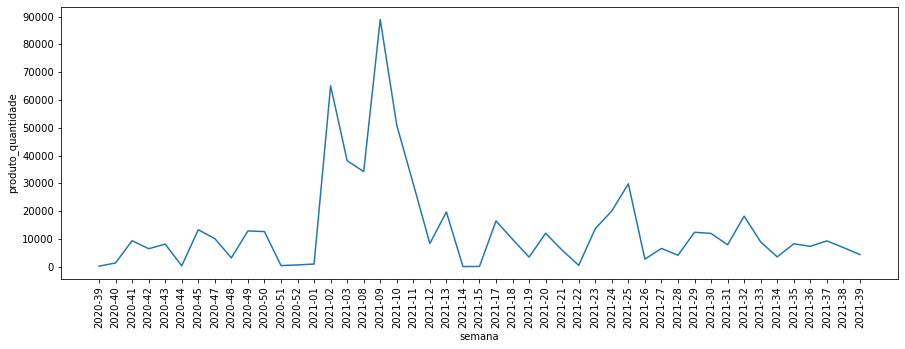

In [17]:
fig = plt.figure(figsize=(15,5))
ax = sns.lineplot(x=produto.index, y='produto_quantidade', data=produto, ci=None)
plt.locator_params(nbins=15)
plt.xticks(rotation=90);

Conforme previsto, os dados apresentam alguns "picos" (ou _outliers_), porém não apresenta nenhuma tendência ou sazonalidade.
A análise continua para o log desses valores:

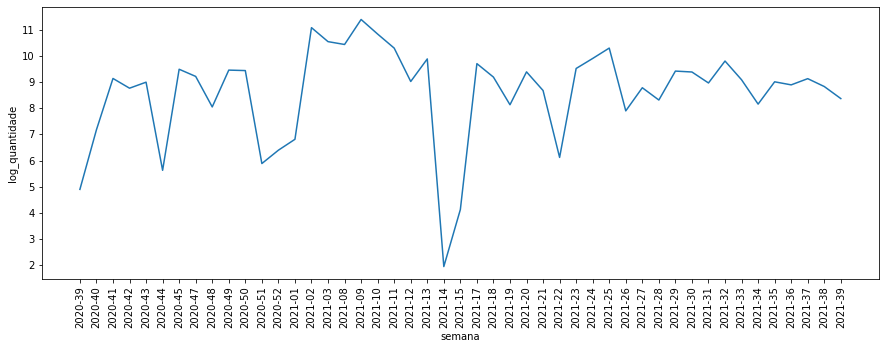

In [18]:
fig = plt.figure(figsize=(15,5))
ax = sns.lineplot(x=produto.index, y='log_quantidade', data=produto, ci=None)
plt.locator_params(nbins=15)
plt.xticks(rotation=90);

O gráfico, à princípio, também apresenta alguns _outliers_ e demonstra ausência de tendência e sazonalidade, conforme o gráfico anterior. Para confirmar a existência de _outliers_, analisaremos os valores de _log_quantidade_ através de um _boxplot_:

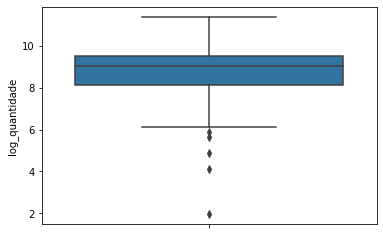

In [19]:
sns.boxplot(y='log_quantidade', data=produto);

Apesar de haver _outliers_, os mesmos não serão excluídos, pois podem conter informações importantes sobre a variável em análise.

### 3. Modelagem

A base de dados será dividida entre treino (80%) e teste (20%), considerando o tempo:

In [20]:
df_train = produto.iloc[:37,:]
df_test = produto.iloc[37:,:]

Após a divisão entre treino e teste, realizaremos o teste Dickey-Fuller Aumentado (_ADF_) para verificar a estacionariedade do modelo. A estacionariedade da série temporal é um elemento importante da análise, pois uma série não estacionária pode gerar resultados espúrios e, por isso, o teste ADF aborda esse detalhe, onde a hipótese nula ($H_{0}$) aponta para a não estacionariedade.

In [21]:
# Augmented Dickey-Fuller test
adf_test = adfuller(df_train['log_quantidade'])

adf_result = pd.Series(adf_test[0:4], index=['Test Statistic:', 'p-value:', 'Lags:', 'Observations:'])
for key, value in adf_test[4].items():
    adf_result['Critical Value (%s):'%key] = value

adf_result

Test Statistic:          -4.508078
p-value:                  0.000190
Lags:                     0.000000
Observations:            36.000000
Critical Value (1%):     -3.626652
Critical Value (5%):     -2.945951
Critical Value (10%):    -2.611671
dtype: float64

Com os resultados do teste ADF, podemos ver que os dados se tratam de uma série estacionária, pois a estatística do teste (-4.5) é menor que o valor crítico de 1% (-3.62), assim, gerando um p-valor > 1% e rejeitando a hipótese nula.
Após o resultado acerca da estacionariedade do modelo, prosseguiremos com a análise da autocorrelação (ACF) e autocorrelação parcial (PACF) para analisar as defasagens ótimas para o modelo:

In [22]:
lag_acf = acf(df_train['log_quantidade'])
lag_pacf = pacf(df_train['log_quantidade'])

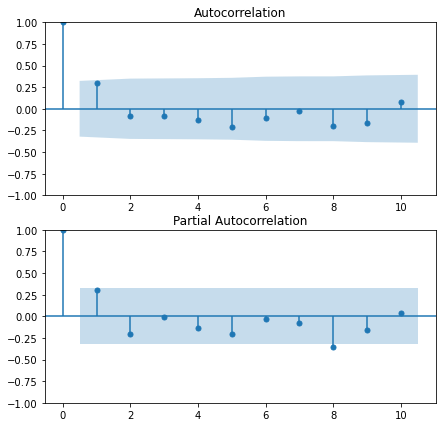

In [23]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train['log_quantidade'], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train['log_quantidade'], lags=10, ax=ax2)

Conforme exibido pela análise acima, pode-se constatar que as defasagens ótimas para a auto-regressão (AR) e a média móvel (MA) são de 1 _lag_.
A seguir, o modelo ARIMA será treinado com as defasagens indicadas:

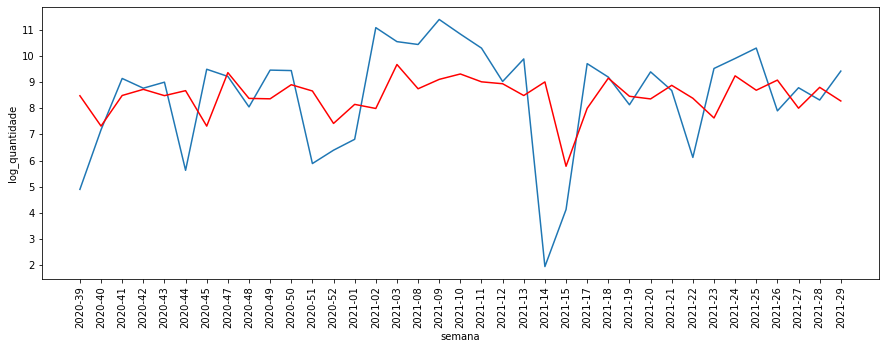

In [24]:
arma = ARIMA(df_train['log_quantidade'], order=(1,0,1))
results = arma.fit()
fig = plt.figure(figsize=(15,5))
ax = sns.lineplot(x=df_train.index, y='log_quantidade', data=df_train, ci=None)
ax = sns.lineplot(x=df_train.index, y=results.fittedvalues, color='red')
plt.locator_params(nbins=15)
plt.xticks(rotation=90);

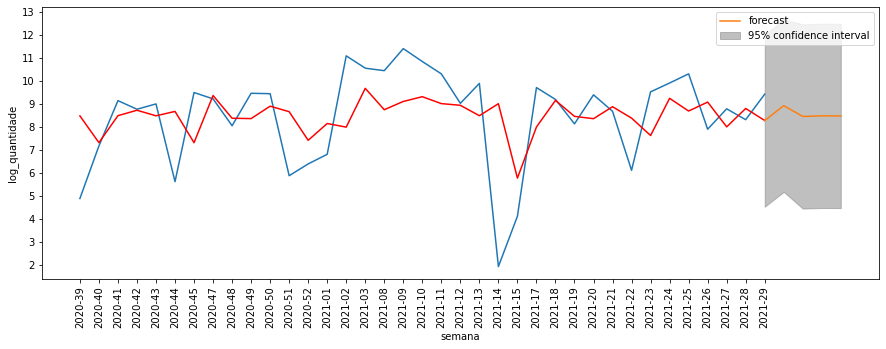

In [25]:
fig = plt.figure(figsize=(15,5))
ax = sns.lineplot(x=df_train.index, y='log_quantidade', data=df_train, ci=None)
ax = sns.lineplot(x=df_train.index, y=results.fittedvalues, color='red')
plot_predict(results, start=36,end=40, dynamic=False, ax=ax)
results.forecast(4)
plt.locator_params(nbins=15)
plt.xticks(rotation=90);

Acima podemos ver a previsão para as próximas 4 semanas e seu respectivo intervalo de confiança.
A seguir iremos comparar os valores gerados pela previsão e os valores verdadeiros (_df_test_):

In [26]:
forecast = list(results.forecast(10))
actual = list(df_test.iloc[:,2])
data = {'verdadeiro': actual,
       'previsão': forecast}

In [27]:
actual_forecast = pd.DataFrame(data)
actual_forecast

,verdadeiro,previsão
0,9.387649,8.922392
1,8.967887,8.455840
2,9.806811,8.480725
3,9.090205,8.479398
4,8.159661,8.479469
5,9.012255,8.479465
6,8.895356,8.479465
7,9.132919,8.479465
8,8.831858,8.479465
9,8.371011,8.479465


In [28]:
MAPE = mean_absolute_percentage_error(actual_forecast.iloc[:,0], actual_forecast.iloc[:,1])
print('MAPE: ' + str(round(MAPE,2)))

MAPE: 0.06


In [29]:
RMSE = sqrt(mean_squared_error(actual_forecast.iloc[:,0], actual_forecast.iloc[:,1]))
print('RMSE: ' + str(round(RMSE, 2)))

RMSE: 0.61


Conforme visto acima, o _mean absolute percentage error_ (MAPE) e o _root mean squared error_ (RMSE) resultaram em 0.06 e 0.61, respectivamente. Podemos perceber que, apesar dos _outliers_ existentes nos dados, ambas as métricas apresentam bons valores e o modelo demonstra ser eficiente, onde as previsões possuem um erro médio de 6% em relação aos valores reais.

Segundo a teoria econômica, o preço (aqui representado pela variável _produto_valor_unitario_comercializacao_) também afeta a demanda, sendo assim, futuras análises podem desenvolver modelos multivariáveis de séries temporais que endogeneizem esse fator, como por exemplo, o modelo de Vetores Auto-Regressivos (VAR) ou o modelo de Vetor de Correção de Erros (VEC), com isso, os resultados poderão exibir a dinâmica entre ambas as variáveis, gerando resultados e previsões mais precisos através de funções impulso-resposta (IRFs) e decomposição da variância.